# Synthetic Photometry and SED Fitting

In [1]:
# Basic installs

import numpy as np
import matplotlib.pyplot as plt
import math
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn, vstack
from astropy.io import fits
from astropy import table
import glob
import os

## Synthetic Photometry

In [2]:
# Functions

def synth_flux(filter_name,model_lam,model_flux):
    '''
    Calculates the synthetic photometric flux for the input model with the
    input filter transmission file.

    Parameters:
    filter_name: The filter file containing the wavelength (Angstroms) 
                    and intensity (erg/s/cm^2/A)
    model_lam: The model wavelengths in Angstroms
    model_flux: The model flux in erg/s/cm^2/A

    Returns:
    flux: The synthetic flux in erg/s/cm^2/A
    '''
    filter_lam = filter_name.columns[0]
    filter_flux = filter_name.columns[1]
    
    f_lam=np.zeros(len(filter_lam))
    for i in range(len(f_lam)):
        # This interpolates the model flux along the same wavelengths as the
        # transmission curve. This needs to be done for the integration to work
        f_lam[i]=np.interp(filter_lam[i],model_lam,model_flux)
    
    # Multiply the (interpolated) model flux by the filter intensity, and integrate
    top = np.trapezoid(np.multiply(f_lam,filter_flux),x=filter_lam)
    # Integrate the filter intensity alone
    bottom = np.trapezoid(filter_flux,x=filter_lam)
    # Divide!
    flux = top/bottom
    
    return flux


def flux_to_mag(flux,zp):
    '''
    Converts a flux to a magnitude given the zero point.

    Parameters:
    flux: flux in erg/s/cm^2/A
    zp: Zero point in erg/s/cm^2/A

    Returns:
    mag: Magnitude
    '''

    mag = (-2.5)*np.log10(flux/zp)

    return mag

def synth_mag(filter_name,model_lam,model_flux,zp):
    '''
    Calculates the synthetic magnitude for the input model using the input
    filter transmission and a zero point.

    Parameters:
    filter_name: The filter file containing the wavelength (Angstroms) 
                    and intensity (erg/s/cm^2/A)
    model_lam: The model wavelengths in Angstroms
    model_flux: The model flux in erg/s/cm^2/A
    zp: Zero point in erg/s/cm^2/A

    Returns:
    mag: Magnitude
    '''

    flux = synth_flux(filter_name,model_lam,model_flux)
    mag = flux_to_mag(flux,zp)
    return mag

### Example

In [3]:
# Load in filter functions
col_names=['lam','flux']
tmass_j=ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.J_v3.09069e-10_ab7.12762e-10_eff12350.dat',
                   names=col_names,data_start=0)
tmass_h=ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.H_v1.11933e-10_ab4.01901e-10_eff16620.dat',
                   names=col_names,data_start=0)
tmass_k=ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.Ks_v4.20615e-11_ab2.33246e-10_eff21590.dat',
                   names=col_names,data_start=0)
# Get their zero points, using AB for now
tmass_j_zp=7.12762e-10
tmass_h_zp=4.01901e-10
tmass_k_zp=2.33246e-10

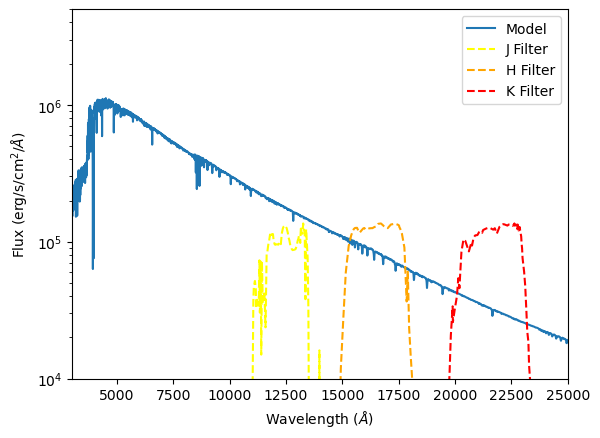

In [4]:
# Load in example spectrum
ex_wave=ascii.read('./pysynphot_data/grid/bosz/bosz2024_wave_r1000.txt',
                   names=['wave'],data_start=0)
ex_flux=ascii.read('./pysynphot_data/grid/bosz/bosz2024_ms_t6000_g+1.0_m+0.00_a+0.00_c+0.00_v0_r1000_resam.txt',
                   names=['flux','cont'],data_start=0)
plt.plot(ex_wave['wave'],ex_flux['flux'],
         '-',c='C0',label='Model')
plt.plot(tmass_j['lam'],tmass_j['flux']*np.mean(ex_flux['flux']),
         '--',c='yellow',label='J Filter')
plt.plot(tmass_h['lam'],tmass_h['flux']*np.mean(ex_flux['flux']),
         '--',c='orange',label='H Filter')
plt.plot(tmass_k['lam'],tmass_k['flux']*np.mean(ex_flux['flux']),
         '--',c='red',label='K Filter')
plt.yscale('log')
plt.xlim(3000,25000)
plt.ylim(1e4,5e6)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Flux (erg/s/cm$^2$/$\AA$)')
plt.legend()

In [5]:
# Calculate synthetic photometry for your 3 magnitudes
ex_jmag=synth_mag(tmass_j,ex_wave['wave'],ex_flux['flux'],tmass_j_zp)
ex_hmag=synth_mag(tmass_h,ex_wave['wave'],ex_flux['flux'],tmass_h_zp)
ex_kmag=synth_mag(tmass_k,ex_wave['wave'],ex_flux['flux'],tmass_k_zp)
model_mags=[ex_jmag,ex_hmag,ex_kmag]
print(model_mags)

[np.float64(-36.01304736469078), np.float64(-35.79588795248143), np.float64(-35.36203391952008)]


## Chi^2 SED Fitting

In [6]:
# Functions
def rchi2_with_err(star_mags,star_err,model_mags):
    '''
    Returns the reduced chi^2, accounting for errors
    Parameters:
        star_mags: Observed magnitudes
        star_err: Uncertainty on the observed magnitudes
        model_mags: Model magnitudes
    Returns:
        rchi2: Reduced chi^2 value
    '''
    N = len(star_mags)
    z = (star_mags-model_mags)/star_err
    rchi2 = np.sum(z**2)/(N-1)
    return rchi2

### Example

In [7]:
# Let's say a star we're interested in has the following J, H, and K magnitudes
star_mags=[13.0,13.5,14.0]
star_errs=[0.2,0.2,0.2]

In [8]:
# First, shift the model magnitudes such the K-band magnitudes align
mag_shift = star_mags[2]-model_mags[2]
# You have to subtract, because magnitudes are weird!
model_mags_shifted = model_mags + mag_shift

In [9]:
# Calculate the reduced chi^2 value
rchi2_with_err(star_mags,star_errs,model_mags_shifted)

np.float64(1.5770863050888002)

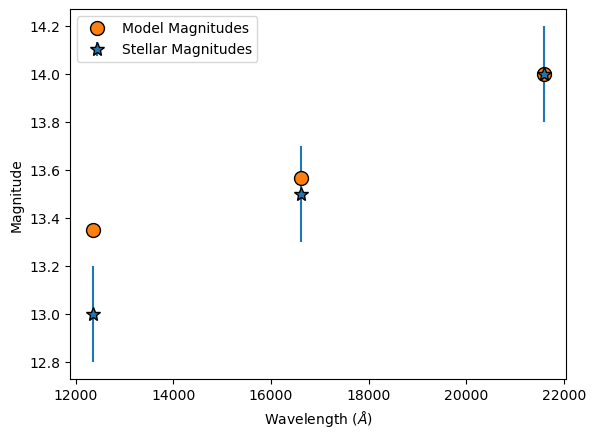

In [10]:
# Plot, using the "effective" wavelength of the 2 MASS filters
tmass_j_lam=12350.0
tmass_h_lam=16620.0
tmass_k_lam=21590.0
tmass_lams=[tmass_j_lam,tmass_h_lam,tmass_k_lam]

plt.errorbar(tmass_lams,star_mags,yerr=star_errs,
             ms=10,fmt='*',mec='k',mfc='C0',ecolor='C0',label='Stellar Magnitudes')
plt.plot(tmass_lams,model_mags_shifted,
         'o',ms=10,mec='k',mfc='C1',label='Model Magnitudes')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Magnitude')
plt.legend(loc='upper left')

In [11]:
# Not bad!